<a href="https://colab.research.google.com/github/nattntn/7-23yrs_EffNet/blob/main/Transfer_with_Gender/Test/7_23_03_Eff_Classify_Predict_250Freeze_Unflipped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##เรียกใช้ CSV

In [ ]:
#เชื่อม google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import

In [ ]:
import os
import numpy as np
import pandas as pd
#import efficientnet.tfkeras
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

# Clone Efficient

In [ ]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1100 (delta 133), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1100/1100), 14.10 MiB | 6.38 MiB/s, done.
Resolving deltas: 100% (630/630), done.
/content/efficientnet_keras_transfer_learning


# Load Model

In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Unflipped_Classification_Gender(7-23)/3_Class_1e-4_250_Freeze.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})


In [ ]:
from tensorflow.keras.models import load_model
model = tf.keras.models.load_model("/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Unflipped_Classification_Gender(7-23)/3_Class_1e-4_250_Freeze.h5")
model.summary()

Model: "EffNet_Classification"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 swish (Swish)               (None, 112, 112, 32)         0         ['batch_no

In [ ]:
height = width = model.input_shape[1]
print(f"height: {height}, width: {width}")

height: 224, width: 224


# Data Preparation

In [ ]:
train =pd.read_csv(r'/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Unflipped_Multi_task(All)(7-23)/table_train_7_23_fold.csv')
train

,Unnamed: 0,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class
0,0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V1.jpg,2,0
1,1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV1.jpg,4,0
2,2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V2.jpg,10,0
3,3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV2.jpg,9,0
4,4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V3.jpg,10,0
...,...,...,...,...,...,...,...,...,...
3780,3780,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipE429.jpg,10,1
3781,3781,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E430.jpg,6,1
3782,3782,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipE430.jpg,10,1
3783,3783,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E431.jpg,10,1


In [ ]:
train = train.iloc[:,1:]

In [ ]:
DATA_PATH = "/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Data_Cut_images"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'Normal')
print(train_dir)
test_dir = os.path.join(DATA_PATH, 'Test')
print(test_dir)

/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Data_Cut_images/Normal
/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Data_Cut_images/Test


In [ ]:
batch_size = 16

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      # horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = DATA_PATH,
        x_col = 'Path_Name',
        y_col = 'Gender_Class',
        class_mode = 'raw',
        color_mode= 'rgb',
        target_size=(height, width),# รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        batch_size=batch_size)
#label
#labels = (train_generator.class_indices)
#labels = dict((v,k) for k,v in labels.items())
#print(labels)

Found 3785 validated image filenames.


In [ ]:
test = pd.read_csv (r'/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Unflipped_Multi_task(All)(7-23)/table_test_7_23_forGender.csv')
test

,Unnamed: 0,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict
0,0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V69.jpg,0,Female
1,1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV69.jpg,0,Female
2,2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V70.jpg,0,Female
3,3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV70.jpg,0,Female
4,4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V74.jpg,0,Female
...,...,...,...,...,...,...,...,...,...
837,930,20,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Q49.jpg,0,Female
838,931,20,M,Abnormal,Lt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipQ412.jpg,1,Male
839,932,21,M,Abnormal,Lt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipN379.jpg,1,Male
840,933,22,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,U136.jpg,0,Female


In [ ]:
test = test.iloc[:,1:]
test

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V69.jpg,0,Female
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV69.jpg,0,Female
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V70.jpg,0,Female
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV70.jpg,0,Female
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V74.jpg,0,Female
...,...,...,...,...,...,...,...,...
837,20,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Q49.jpg,0,Female
838,20,M,Abnormal,Lt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipQ412.jpg,1,Male
839,21,M,Abnormal,Lt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipN379.jpg,1,Male
840,22,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,U136.jpg,0,Female


# Predict

In [ ]:
act_int = test['Gender_Class'].tolist() #ค่าจริง
path = test['Path_Name'].tolist() #path

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width)) #รูปทุกรูปมีขนาดไม่เท่ากันจึงตั้งไว้ว่าเวลาจะให้ model ดึงรูปมาทำนายให้ดึงรูปเข้ามาตามขนาดที่ตั้งไว้ตามพารามิตเตอร์
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)  #model ไม่สามารถทำนายรูปภาพโดยตรงได้ จึงเเปลงรูปภาพให้เป็น array เเล้วให้โมเดลทำนาย
    # Reshape
    x = x.reshape((1,) + x.shape) # เพิ่ม ไดเมนชั่นของโมเดล ให้เป็น 4 ได้ เมนชั่น โดยที่ 1, คือบอกให้โมเดลนำเข้าทีละ 1 รูปเเล้วค่อยทำนาย เเละ + ไดเมนชั่น คือ 150 ,150 ,3(สีของ RGB)
    x /= 255.
    result = model.predict([x])
    return result[0]

In [ ]:
predict_image(path[0])[0]

1/1 [==============================] - 4s 4s/step


0.6467594

In [ ]:
#Predict
pred_list = list()
prob_list = list()
img_path= path
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = predict[0]
    re_prop = np.argmax(predict)
    pred_list.append(result)
    prob_list.append(predict[re_prop])

1/1 [==============================] - 0s 36ms/step


In [ ]:
pred_list

[0.6467594,
 0.2300613,
 0.8001473,
 0.6446156,
 0.789602,
 0.07797956,
 0.12230424,
 0.04446656,
 0.7293077,
 0.1654971,
 0.25518638,
 0.2574773,
 0.009524671,
 0.020807257,
 0.09451638,
 0.031340234,
 0.4223759,
 0.328318,
 0.43851978,
 0.78015834,
 0.68920505,
 0.76384157,
 0.049674988,
 0.034913752,
 0.41539246,
 0.05376366,
 0.006972483,
 0.86976844,
 0.7151799,
 0.21794303,
 0.64352185,
 0.5195817,
 0.1555119,
 0.24557555,
 0.08904903,
 0.028918695,
 0.013058365,
 0.2783177,
 0.28098938,
 0.46777067,
 0.5916004,
 0.18133369,
 0.24383229,
 0.45491874,
 0.9249298,
 0.7965086,
 0.78506565,
 0.2136497,
 0.2823376,
 0.27816692,
 0.10749266,
 0.5036568,
 0.4128426,
 0.83850056,
 0.3103582,
 0.05423591,
 0.11780914,
 0.6993961,
 0.33155584,
 0.03596056,
 0.15868898,
 0.5324538,
 0.22367784,
 0.014033859,
 0.050562162,
 0.15303613,
 0.07303784,
 0.063809596,
 0.0667254,
 0.78785354,
 0.6849761,
 0.010698461,
 0.026431488,
 0.115325004,
 0.14892298,
 0.039381295,
 0.014931654,
 0.5542872,

In [ ]:
print(type(pred_list))

<class 'list'>


In [ ]:
list_pred = []
# ใช้ลูป for เพื่อแปลงค่าและเพิ่มเข้าใน NumPy array
for value in pred_list:
    if value >= 0.5:
        list_pred = np.append(list_pred, 'Male')
    else:
        list_pred = np.append(list_pred, 'Female')

# แสดงผลลัพธ์
print(list_pred)

['Male' 'Female' 'Male' 'Male' 'Male' 'Female' 'Female' 'Female' 'Male'
 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female'
 'Female' 'Female' 'Male' 'Male' 'Male' 'Female' 'Female' 'Female'
 'Female' 'Female' 'Male' 'Male' 'Female' 'Male' 'Male' 'Female' 'Female'
 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Male' 'Female'
 'Female' 'Female' 'Male' 'Male' 'Male' 'Female' 'Female' 'Female'
 'Female' 'Male' 'Female' 'Male' 'Female' 'Female' 'Female' 'Male'
 'Female' 'Female' 'Female' 'Male' 'Female' 'Female' 'Female' 'Female'
 'Female' 'Female' 'Female' 'Male' 'Male' 'Female' 'Female' 'Female'
 'Female' 'Female' 'Female' 'Male' 'Female' 'Female' 'Female' 'Male'
 'Female' 'Female' 'Female' 'Female' 'Female' 'Male' 'Male' 'Male' 'Male'
 'Male' 'Male' 'Male' 'Female' 'Male' 'Female' 'Female' 'Female' 'Male'
 'Male' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female'
 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female' 'Female'
 'Female' 

In [ ]:
test['Predict_float'] = pred_list
test['Predict_str'] = list_pred
# แสดง DataFrame
test

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict,Predict_float,Predict_str
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V69.jpg,0,Female,0.646759,Male
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV69.jpg,0,Female,0.230061,Female
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V70.jpg,0,Female,0.800147,Male
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV70.jpg,0,Female,0.644616,Male
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V74.jpg,0,Female,0.789602,Male
...,...,...,...,...,...,...,...,...,...,...
837,20,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Q49.jpg,0,Female,0.008673,Female
838,20,M,Abnormal,Lt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipQ412.jpg,1,Male,0.710817,Male
839,21,M,Abnormal,Lt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipN379.jpg,1,Male,0.890949,Male
840,22,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,U136.jpg,0,Female,0.176568,Female


In [ ]:
#test.to_csv('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/EfficientNet_Class_Func_224/Table_test_Predict_Gender224.csv')

In [ ]:
# test = pd.read_csv('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/EfficientNet_Class_Func_224/Table_test_Predict_Gender224.csv')

In [ ]:
test

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict,Predict_float,Predict_str
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V69.jpg,0,Female,0.646759,Male
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV69.jpg,0,Female,0.230061,Female
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V70.jpg,0,Female,0.800147,Male
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV70.jpg,0,Female,0.644616,Male
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V74.jpg,0,Female,0.789602,Male
...,...,...,...,...,...,...,...,...,...,...
837,20,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Q49.jpg,0,Female,0.008673,Female
838,20,M,Abnormal,Lt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipQ412.jpg,1,Male,0.710817,Male
839,21,M,Abnormal,Lt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipN379.jpg,1,Male,0.890949,Male
840,22,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,U136.jpg,0,Female,0.176568,Female


# Evaluate All

In [ ]:
pred_str = np.array(list_pred) #แปลงเป็น array
act_str = np.array(test['Gender_Predict'].tolist())

pred_int = np.array(pred_list) #แปลงเป็น array
act_int = test['Gender_Class'].tolist() #ค่าจริง

## confusion_matrix

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act_str, pred_str)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act_str, pred_str))#performance

classifier accuracy = 74.94061757719714%
              precision    recall  f1-score   support

      Female       0.71      0.86      0.78       424
        Male       0.82      0.64      0.72       418

    accuracy                           0.75       842
   macro avg       0.76      0.75      0.75       842
weighted avg       0.76      0.75      0.75       842



Text(0.5, 76.24999999999999, 'Predicted label')

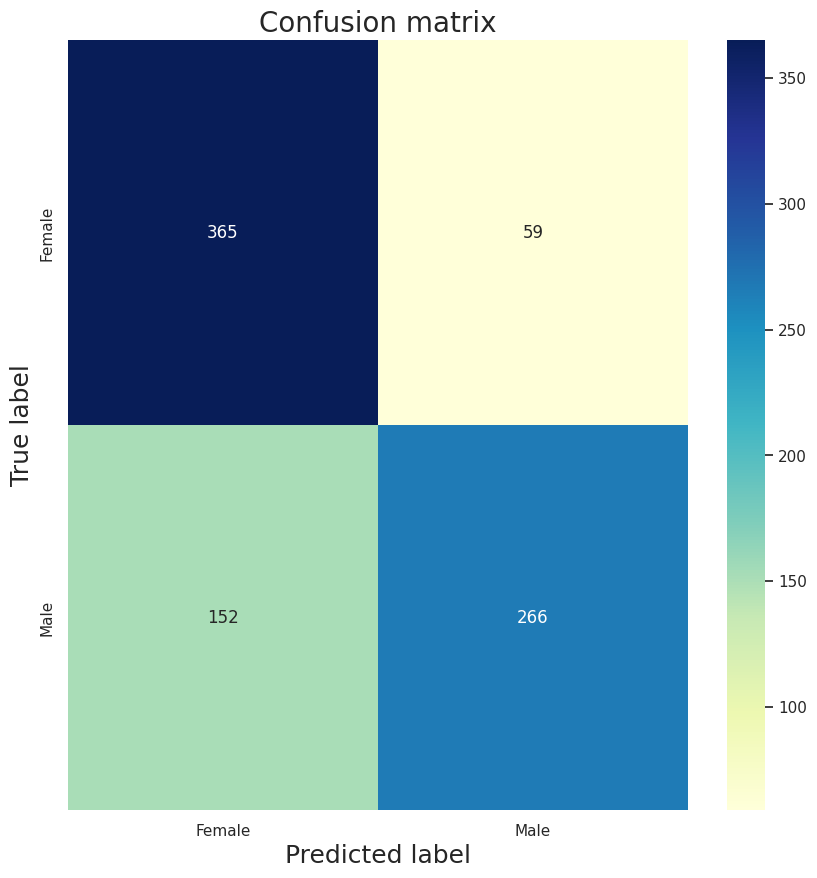

In [ ]:
#create CF
data = {'Actual': act_str,'Predicted' : pred_str}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act_str, pred_str)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

## MSE and MAE

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(act_int,pred_int)
mse = mean_squared_error(act_int,pred_int)
rmse = mean_squared_error(act_int,pred_int,squared=False)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 0.3062969033490626
MSE: 0.17349889624081294
RMSE: 0.4165319870559918


# ROC

In [ ]:
pred_list

[0.6467594,
 0.2300613,
 0.8001473,
 0.6446156,
 0.789602,
 0.07797956,
 0.12230424,
 0.04446656,
 0.7293077,
 0.1654971,
 0.25518638,
 0.2574773,
 0.009524671,
 0.020807257,
 0.09451638,
 0.031340234,
 0.4223759,
 0.328318,
 0.43851978,
 0.78015834,
 0.68920505,
 0.76384157,
 0.049674988,
 0.034913752,
 0.41539246,
 0.05376366,
 0.006972483,
 0.86976844,
 0.7151799,
 0.21794303,
 0.64352185,
 0.5195817,
 0.1555119,
 0.24557555,
 0.08904903,
 0.028918695,
 0.013058365,
 0.2783177,
 0.28098938,
 0.46777067,
 0.5916004,
 0.18133369,
 0.24383229,
 0.45491874,
 0.9249298,
 0.7965086,
 0.78506565,
 0.2136497,
 0.2823376,
 0.27816692,
 0.10749266,
 0.5036568,
 0.4128426,
 0.83850056,
 0.3103582,
 0.05423591,
 0.11780914,
 0.6993961,
 0.33155584,
 0.03596056,
 0.15868898,
 0.5324538,
 0.22367784,
 0.014033859,
 0.050562162,
 0.15303613,
 0.07303784,
 0.063809596,
 0.0667254,
 0.78785354,
 0.6849761,
 0.010698461,
 0.026431488,
 0.115325004,
 0.14892298,
 0.039381295,
 0.014931654,
 0.5542872,

In [ ]:
prob_list

[0.6467594,
 0.2300613,
 0.8001473,
 0.6446156,
 0.789602,
 0.07797956,
 0.12230424,
 0.04446656,
 0.7293077,
 0.1654971,
 0.25518638,
 0.2574773,
 0.009524671,
 0.020807257,
 0.09451638,
 0.031340234,
 0.4223759,
 0.328318,
 0.43851978,
 0.78015834,
 0.68920505,
 0.76384157,
 0.049674988,
 0.034913752,
 0.41539246,
 0.05376366,
 0.006972483,
 0.86976844,
 0.7151799,
 0.21794303,
 0.64352185,
 0.5195817,
 0.1555119,
 0.24557555,
 0.08904903,
 0.028918695,
 0.013058365,
 0.2783177,
 0.28098938,
 0.46777067,
 0.5916004,
 0.18133369,
 0.24383229,
 0.45491874,
 0.9249298,
 0.7965086,
 0.78506565,
 0.2136497,
 0.2823376,
 0.27816692,
 0.10749266,
 0.5036568,
 0.4128426,
 0.83850056,
 0.3103582,
 0.05423591,
 0.11780914,
 0.6993961,
 0.33155584,
 0.03596056,
 0.15868898,
 0.5324538,
 0.22367784,
 0.014033859,
 0.050562162,
 0.15303613,
 0.07303784,
 0.063809596,
 0.0667254,
 0.78785354,
 0.6849761,
 0.010698461,
 0.026431488,
 0.115325004,
 0.14892298,
 0.039381295,
 0.014931654,
 0.5542872,

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [ ]:
# Example: Replace these with your actual labels and predicted probabilities
actual_labels = test['Gender_Class'].tolist()
predicted_probabilities = prob_list

In [ ]:
fpr, tpr, thresholds = roc_curve(actual_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

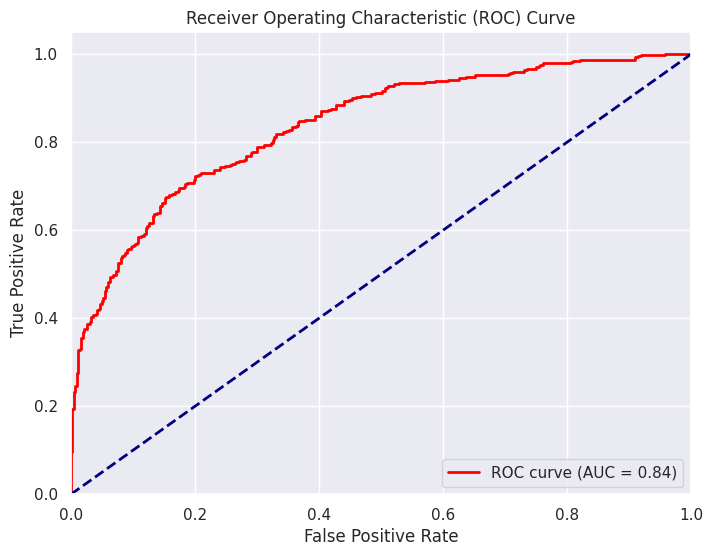

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 7 year

In [ ]:
test

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict,Predict_float,Predict_str
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V69.jpg,0,Female,0.646759,Male
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV69.jpg,0,Female,0.230061,Female
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V70.jpg,0,Female,0.800147,Male
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV70.jpg,0,Female,0.644616,Male
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V74.jpg,0,Female,0.789602,Male
...,...,...,...,...,...,...,...,...,...,...
837,20,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Q49.jpg,0,Female,0.008673,Female
838,20,M,Abnormal,Lt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipQ412.jpg,1,Male,0.710817,Male
839,21,M,Abnormal,Lt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipN379.jpg,1,Male,0.890949,Male
840,22,F,Abnormal,Rt,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,U136.jpg,0,Female,0.176568,Female


In [ ]:
Y7 = test[test['Age(year)'] == 7]
Y7

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict,Predict_float,Predict_str
0,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V69.jpg,0,Female,0.646759,Male
1,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV69.jpg,0,Female,0.230061,Female
2,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V70.jpg,0,Female,0.800147,Male
3,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV70.jpg,0,Female,0.644616,Male
4,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V74.jpg,0,Female,0.789602,Male
5,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV74.jpg,0,Female,0.077980,Female
6,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V75.jpg,0,Female,0.122304,Female
7,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV75.jpg,0,Female,0.044467,Female
8,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,V76.jpg,0,Female,0.729308,Male
9,7,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipV76.jpg,0,Female,0.165497,Female


## confusion_matrix

In [ ]:
pred_str = np.array(Y7['Predict_str'].tolist()) #ทำนาย
act_str = np.array(Y7['Gender_Predict'].tolist()) # จริง

pred_int = np.array(Y7['Predict_float'].tolist())  #แทำนาย
act_int = np.array(Y7['Gender_Class'].tolist()) #ค่าจริง

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act_str, pred_str)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act_str, pred_str))#performance

classifier accuracy = 50.0%
              precision    recall  f1-score   support

      Female       0.50      0.68      0.58        25
        Male       0.50      0.32      0.39        25

    accuracy                           0.50        50
   macro avg       0.50      0.50      0.48        50
weighted avg       0.50      0.50      0.48        50



Text(0.5, 76.24999999999999, 'Predicted label')

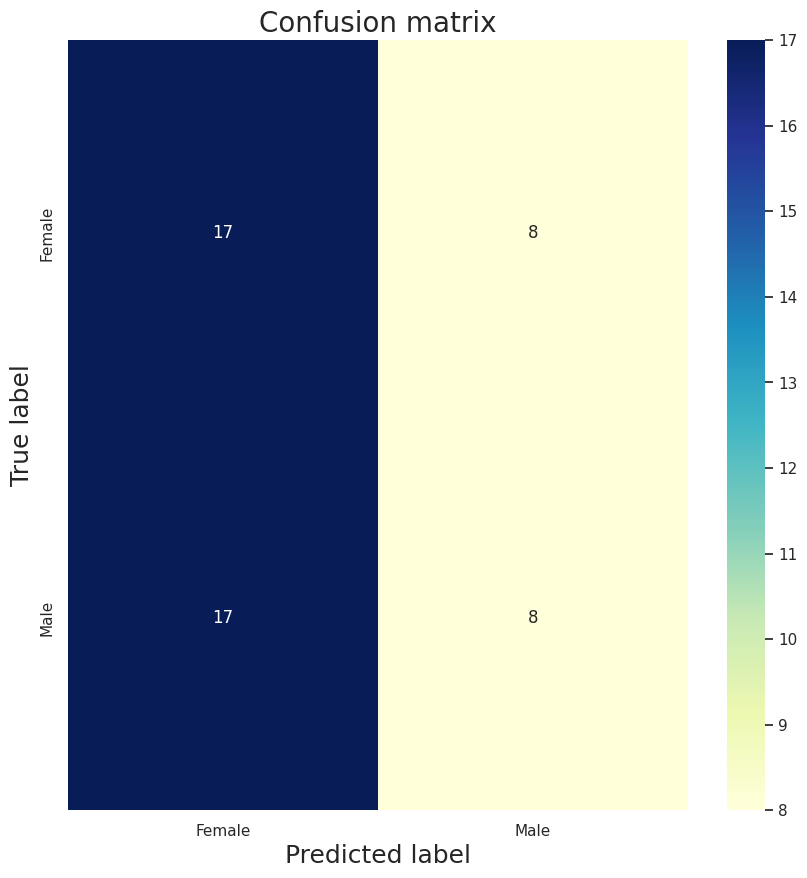

In [ ]:
#create CF
data = {'Actual': act_str,'Predicted' : pred_str}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act_str, pred_str)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

## MSE and MAE

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(act_int,pred_int)
mse = mean_squared_error(act_int,pred_int)
rmse = mean_squared_error(act_int,pred_int,squared=False)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 0.4911919313017279
MSE: 0.3406623055673609
RMSE: 0.5836628355200979


# 8 year

In [ ]:
Y8 = test[test['Age(year)'] == 8]
Y8

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict,Predict_float,Predict_str
49,8,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,P70.jpg,0,Female,0.278167,Female
50,8,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipP70.jpg,0,Female,0.107493,Female
51,8,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,P72.jpg,0,Female,0.503657,Male
52,8,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipP72.jpg,0,Female,0.412843,Female
53,8,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,P74.jpg,0,Female,0.838501,Male
54,8,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipP74.jpg,0,Female,0.310358,Female
55,8,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,P75.jpg,0,Female,0.054236,Female
56,8,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipP75.jpg,0,Female,0.117809,Female
57,8,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,P76.jpg,0,Female,0.699396,Male
58,8,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipP76.jpg,0,Female,0.331556,Female


## confusion_matrix

In [ ]:
pred_str = np.array(Y8['Predict_str'].tolist()) #ทำนาย
act_str = np.array(Y8['Gender_Predict'].tolist()) # จริง

pred_int = np.array(Y8['Predict_float'].tolist())  #แทำนาย
act_int = np.array(Y8['Gender_Class'].tolist()) #ค่าจริง

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act_str, pred_str)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act_str, pred_str))#performance

classifier accuracy = 60.416666666666664%
              precision    recall  f1-score   support

      Female       0.61      0.77      0.68        26
        Male       0.60      0.41      0.49        22

    accuracy                           0.60        48
   macro avg       0.60      0.59      0.58        48
weighted avg       0.60      0.60      0.59        48



Text(0.5, 76.24999999999999, 'Predicted label')

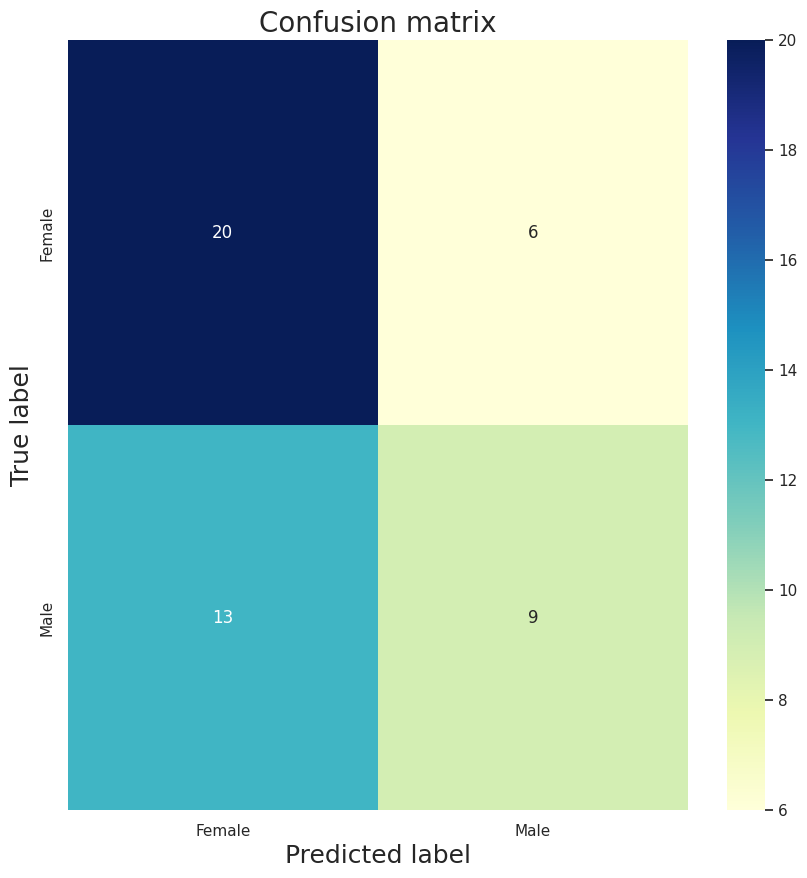

In [ ]:
#create CF
data = {'Actual': act_str,'Predicted' : pred_str}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act_str, pred_str)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

## MSE and MAE

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(act_int,pred_int)
mse = mean_squared_error(act_int,pred_int)
rmse = mean_squared_error(act_int,pred_int,squared=False)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 0.42543240388234455
MSE: 0.2871363990543561
RMSE: 0.5358510978381551


# 9 year

In [ ]:
Y9 = test[test['Age(year)'] == 9]
Y9

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict,Predict_float,Predict_str
94,9,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,W81.jpg,0,Female,0.061028,Female
95,9,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipW81.jpg,0,Female,0.767626,Male
96,9,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,W84.jpg,0,Female,0.069658,Female
97,9,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipW84.jpg,0,Female,0.015819,Female
98,9,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,W85.jpg,0,Female,0.223364,Female
99,9,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipW85.jpg,0,Female,0.615802,Male
100,9,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,W87.jpg,0,Female,0.841243,Male
101,9,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipW87.jpg,0,Female,0.233530,Female
102,9,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,W89.jpg,0,Female,0.067610,Female
103,9,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipW89.jpg,0,Female,0.058546,Female


## confusion_matrix

In [ ]:
pred_str = np.array(Y9['Predict_str'].tolist()) #ทำนาย
act_str = np.array(Y9['Gender_Predict'].tolist()) # จริง

pred_int = np.array(Y9['Predict_float'].tolist())  #แทำนาย
act_int = np.array(Y9['Gender_Class'].tolist()) #ค่าจริง

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act_str, pred_str)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act_str, pred_str))#performance

classifier accuracy = 74.0%
              precision    recall  f1-score   support

      Female       0.71      0.85      0.77        26
        Male       0.79      0.62      0.70        24

    accuracy                           0.74        50
   macro avg       0.75      0.74      0.73        50
weighted avg       0.75      0.74      0.74        50



Text(0.5, 76.24999999999999, 'Predicted label')

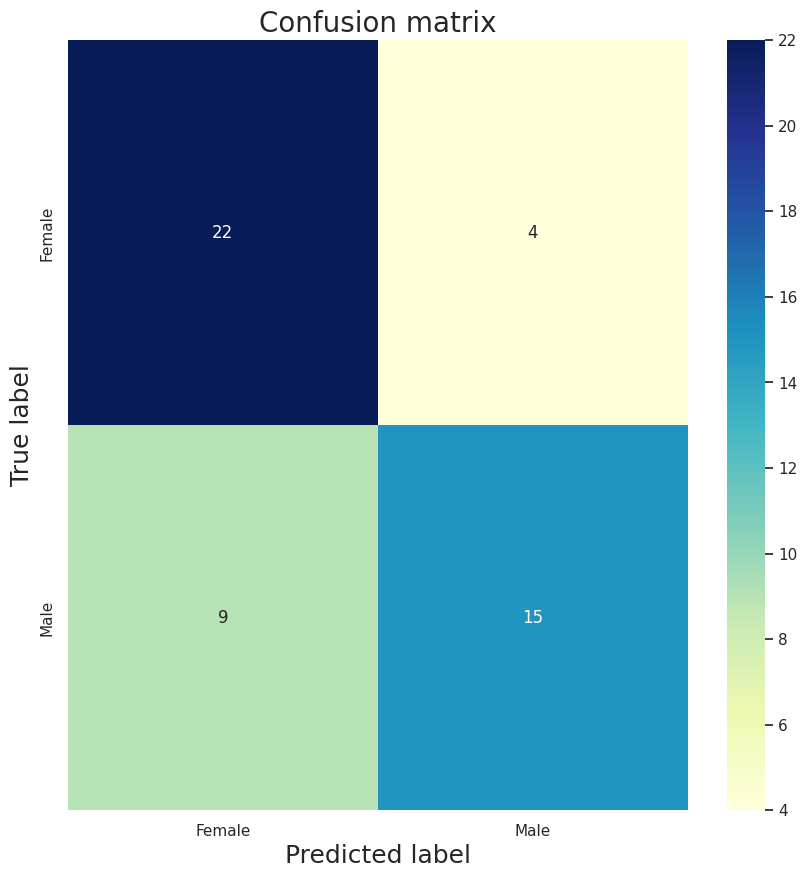

In [ ]:
#create CF
data = {'Actual': act_str,'Predicted' : pred_str}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act_str, pred_str)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

## MSE and MAE

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(act_int,pred_int)
mse = mean_squared_error(act_int,pred_int)
rmse = mean_squared_error(act_int,pred_int,squared=False)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 0.3131895705312491
MSE: 0.16882564970045544
RMSE: 0.41088398569481316


# 10 year

In [ ]:
Y10 = test[test['Age(year)'] == 10]
Y10

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict,Predict_float,Predict_str
141,10,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,H79.jpg,0,Female,0.219323,Female
142,10,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipH79.jpg,0,Female,0.430450,Female
143,10,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,H81.jpg,0,Female,0.758523,Male
144,10,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipH81.jpg,0,Female,0.675001,Male
145,10,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,H82.jpg,0,Female,0.073407,Female
146,10,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipH82.jpg,0,Female,0.149356,Female
147,10,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,H83.jpg,0,Female,0.481177,Female
148,10,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipH83.jpg,0,Female,0.732549,Male
149,10,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,H84.jpg,0,Female,0.545058,Male
150,10,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipH84.jpg,0,Female,0.197721,Female


## confusion_matrix

In [ ]:
pred_str = np.array(Y10['Predict_str'].tolist()) #ทำนาย
act_str = np.array(Y10['Gender_Predict'].tolist()) # จริง

pred_int = np.array(Y10['Predict_float'].tolist())  #แทำนาย
act_int = np.array(Y10['Gender_Class'].tolist()) #ค่าจริง

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act_str, pred_str)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act_str, pred_str))#performance

classifier accuracy = 63.265306122448976%
              precision    recall  f1-score   support

      Female       0.68      0.52      0.59        25
        Male       0.60      0.75      0.67        24

    accuracy                           0.63        49
   macro avg       0.64      0.64      0.63        49
weighted avg       0.64      0.63      0.63        49



Text(0.5, 76.24999999999999, 'Predicted label')

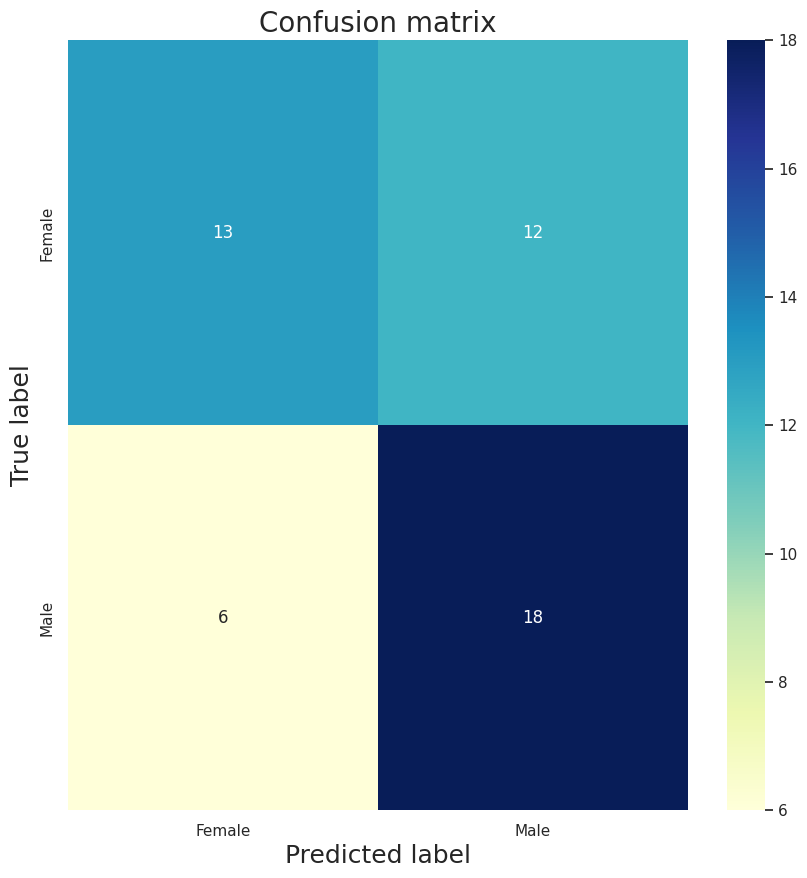

In [ ]:
#create CF
data = {'Actual': act_str,'Predicted' : pred_str}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act_str, pred_str)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

## MSE and MAE

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(act_int,pred_int)
mse = mean_squared_error(act_int,pred_int)
rmse = mean_squared_error(act_int,pred_int,squared=False)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 0.3997431590544934
MSE: 0.23969842714481732
RMSE: 0.4895900603002652


# 11 year

In [ ]:
Y11 = test[test['Age(year)'] == 11]
Y11

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict,Predict_float,Predict_str
188,11,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,D78.jpg,0,Female,0.690203,Male
189,11,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipD78.jpg,0,Female,0.355343,Female
190,11,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,D79.jpg,0,Female,0.661698,Male
191,11,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipD79.jpg,0,Female,0.189187,Female
192,11,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,D83.jpg,0,Female,0.285369,Female
193,11,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipD83.jpg,0,Female,0.708922,Male
194,11,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,D85.jpg,0,Female,0.156387,Female
195,11,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipD85.jpg,0,Female,0.019949,Female
196,11,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,D88.jpg,0,Female,0.195347,Female
197,11,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipD88.jpg,0,Female,0.077625,Female


## confusion_matrix

In [ ]:
pred_str = np.array(Y11['Predict_str'].tolist()) #ทำนาย
act_str = np.array(Y11['Gender_Predict'].tolist()) # จริง

pred_int = np.array(Y11['Predict_float'].tolist())  #แทำนาย
act_int = np.array(Y11['Gender_Class'].tolist()) #ค่าจริง

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act_str, pred_str)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act_str, pred_str))#performance

classifier accuracy = 70.0%
              precision    recall  f1-score   support

      Female       0.67      0.75      0.71        24
        Male       0.74      0.65      0.69        26

    accuracy                           0.70        50
   macro avg       0.70      0.70      0.70        50
weighted avg       0.70      0.70      0.70        50



Text(0.5, 76.24999999999999, 'Predicted label')

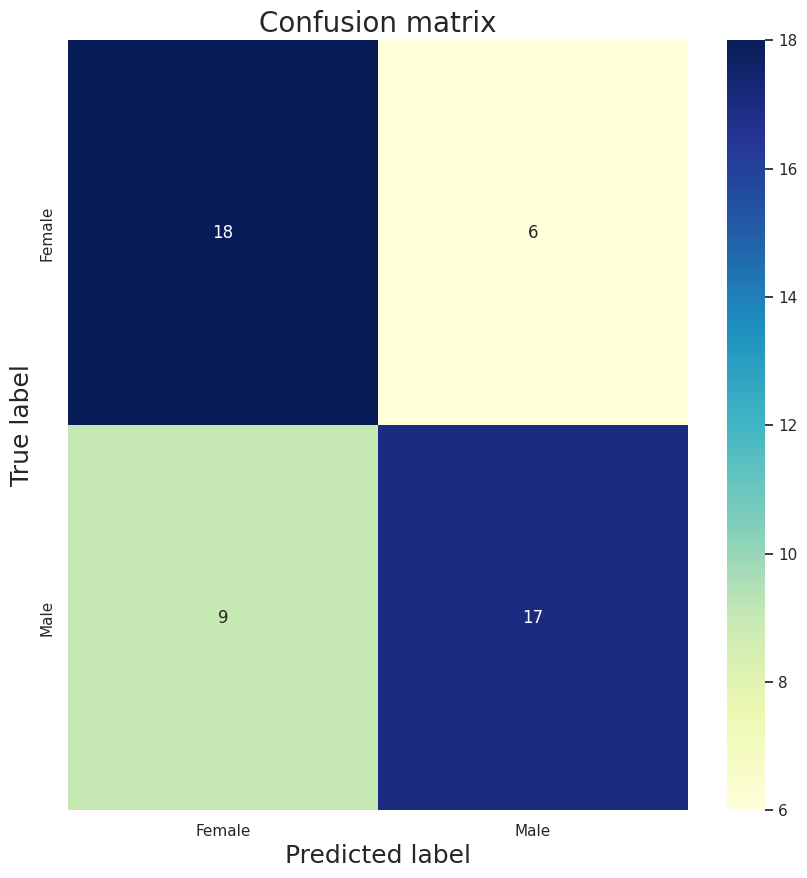

In [ ]:
#create CF
data = {'Actual': act_str,'Predicted' : pred_str}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act_str, pred_str)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

## MSE and MAE

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(act_int,pred_int)
mse = mean_squared_error(act_int,pred_int)
rmse = mean_squared_error(act_int,pred_int,squared=False)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 0.3397532906010747
MSE: 0.18891809968526577
RMSE: 0.4346470978682197


# 12 year

In [ ]:
Y12 = test[test['Age(year)'] == 12]
Y12

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict,Predict_float,Predict_str
237,12,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,O85.jpg,0,Female,0.491416,Female
238,12,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipO85.jpg,0,Female,0.275096,Female
239,12,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,O89.jpg,0,Female,0.323343,Female
240,12,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipO89.jpg,0,Female,0.214351,Female
241,12,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,O90.jpg,0,Female,0.162341,Female
242,12,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipO90.jpg,0,Female,0.445791,Female
243,12,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,O93.jpg,0,Female,0.138025,Female
244,12,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipO93.jpg,0,Female,0.031320,Female
245,12,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,O94.jpg,0,Female,0.116011,Female
246,12,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipO94.jpg,0,Female,0.390114,Female


## confusion_matrix

In [ ]:
pred_str = np.array(Y12['Predict_str'].tolist()) #ทำนาย
act_str = np.array(Y12['Gender_Predict'].tolist()) # จริง

pred_int = np.array(Y12['Predict_float'].tolist())  #แทำนาย
act_int = np.array(Y12['Gender_Class'].tolist()) #ค่าจริง

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act_str, pred_str)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act_str, pred_str))#performance

classifier accuracy = 66.66666666666667%
              precision    recall  f1-score   support

      Female       0.62      0.78      0.69        23
        Male       0.74      0.56      0.64        25

    accuracy                           0.67        48
   macro avg       0.68      0.67      0.66        48
weighted avg       0.68      0.67      0.66        48



Text(0.5, 76.24999999999999, 'Predicted label')

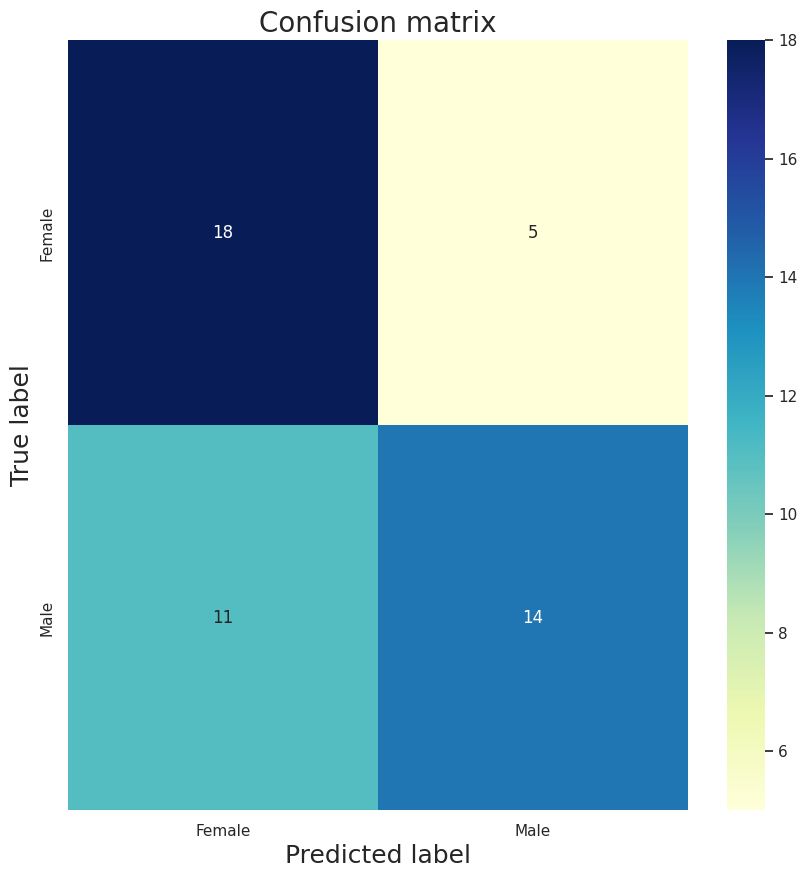

In [ ]:
#create CF
data = {'Actual': act_str,'Predicted' : pred_str}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act_str, pred_str)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

## MSE and MAE

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(act_int,pred_int)
mse = mean_squared_error(act_int,pred_int)
rmse = mean_squared_error(act_int,pred_int,squared=False)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 0.40237276287128526
MSE: 0.23380751327945495
RMSE: 0.4835364653047947


# 13 year

In [ ]:
Y13 = test[test['Age(year)'] == 13]
Y13

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict,Predict_float,Predict_str
281,13,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,G84.jpg,0,Female,0.005467,Female
282,13,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipG84.jpg,0,Female,0.006606,Female
283,13,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,G92.jpg,0,Female,0.076597,Female
284,13,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipG92.jpg,0,Female,0.278485,Female
285,13,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,G93.jpg,0,Female,0.111996,Female
286,13,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipG93.jpg,0,Female,0.086234,Female
287,13,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,G94.jpg,0,Female,0.196378,Female
288,13,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipG94.jpg,0,Female,0.161467,Female
289,13,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,G98.jpg,0,Female,0.890717,Male
290,13,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipG98.jpg,0,Female,0.770578,Male


## confusion_matrix

In [ ]:
pred_str = np.array(Y13['Predict_str'].tolist()) #ทำนาย
act_str = np.array(Y13['Gender_Predict'].tolist()) # จริง

pred_int = np.array(Y13['Predict_float'].tolist())  #แทำนาย
act_int = np.array(Y13['Gender_Class'].tolist()) #ค่าจริง

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act_str, pred_str)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act_str, pred_str))#performance

classifier accuracy = 76.0%
              precision    recall  f1-score   support

      Female       0.72      0.84      0.78        25
        Male       0.81      0.68      0.74        25

    accuracy                           0.76        50
   macro avg       0.77      0.76      0.76        50
weighted avg       0.77      0.76      0.76        50



Text(0.5, 76.24999999999999, 'Predicted label')

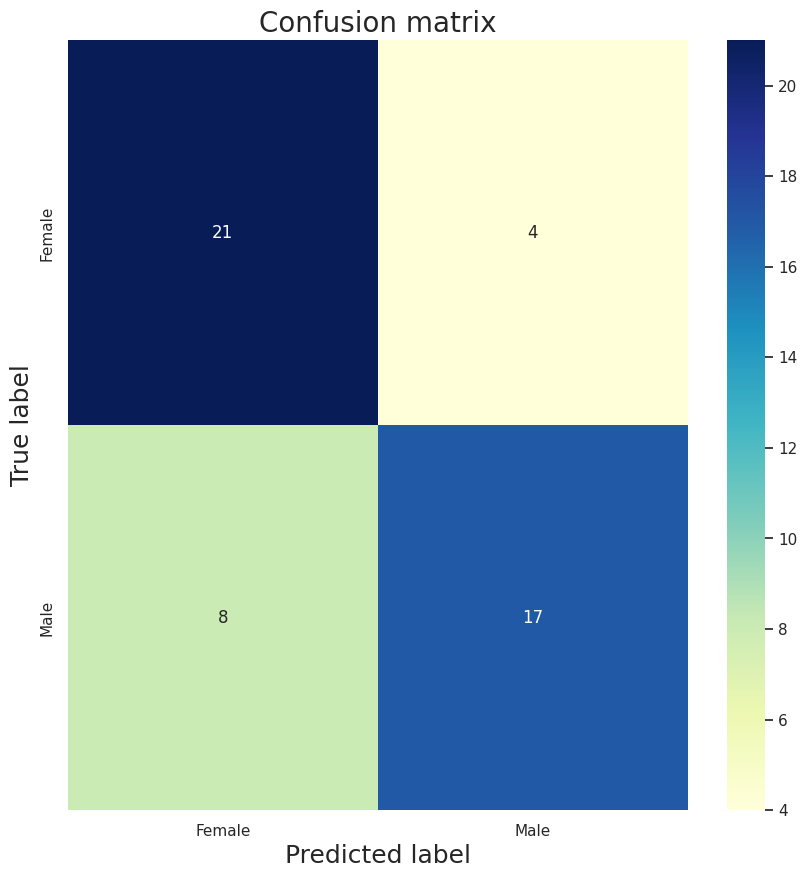

In [ ]:
#create CF
data = {'Actual': act_str,'Predicted' : pred_str}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act_str, pred_str)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

## MSE and MAE

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(act_int,pred_int)
mse = mean_squared_error(act_int,pred_int)
rmse = mean_squared_error(act_int,pred_int,squared=False)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 0.30775290112011133
MSE: 0.15351221541703552
RMSE: 0.39180634938325787


# 14 year

In [ ]:
Y14 = test[test['Age(year)'] == 14]
Y14

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Gender_Class,Gender_Predict,Predict_float,Predict_str
331,14,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Y96.jpg,0,Female,0.027703,Female
332,14,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipY96.jpg,0,Female,0.083201,Female
333,14,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Y98.jpg,0,Female,0.064188,Female
334,14,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipY98.jpg,0,Female,0.023002,Female
335,14,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Y99.jpg,0,Female,0.081951,Female
336,14,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipY99.jpg,0,Female,0.385000,Female
337,14,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Y101.jpg,0,Female,0.188594,Female
338,14,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipY101.jpg,0,Female,0.623072,Male
339,14,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,Y104.jpg,0,Female,0.442834,Female
340,14,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipY104.jpg,0,Female,0.081706,Female


## confusion_matrix

In [ ]:
pred_str = np.array(Y14['Predict_str'].tolist()) #ทำนาย
act_str = np.array(Y14['Gender_Predict'].tolist()) # จริง

pred_int = np.array(Y14['Predict_float'].tolist())  #แทำนาย
act_int = np.array(Y14['Gender_Class'].tolist()) #ค่าจริง

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act_str, pred_str)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act_str, pred_str))#performance

classifier accuracy = 74.46808510638297%
              precision    recall  f1-score   support

      Female       0.70      0.92      0.79        25
        Male       0.86      0.55      0.67        22

    accuracy                           0.74        47
   macro avg       0.78      0.73      0.73        47
weighted avg       0.77      0.74      0.73        47



Text(0.5, 76.24999999999999, 'Predicted label')

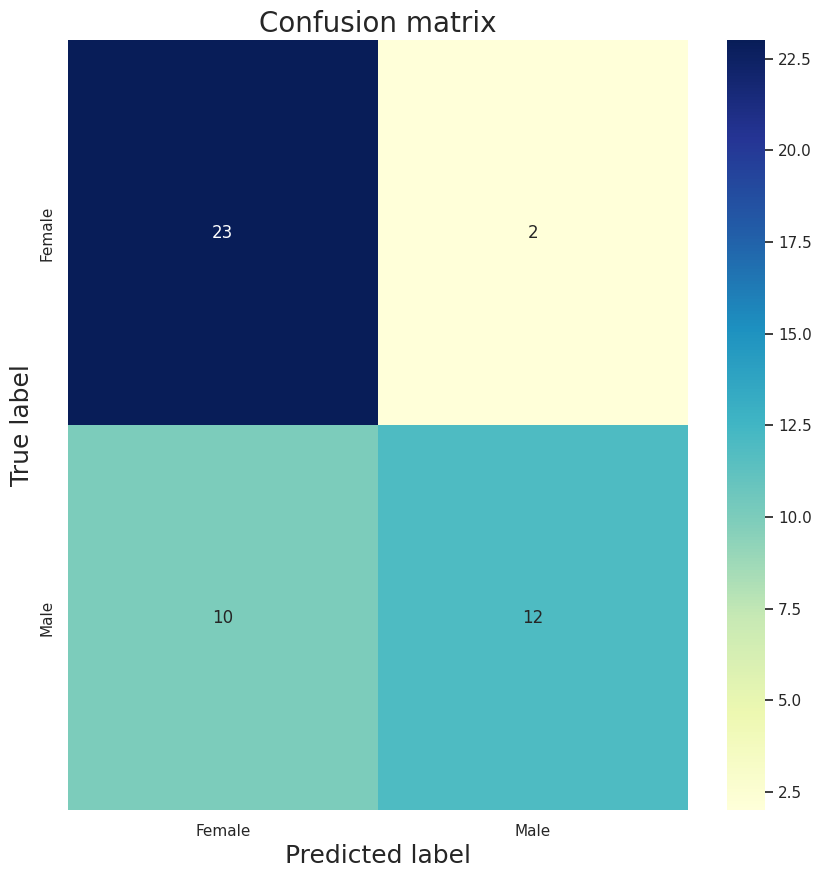

In [ ]:
#create CF
data = {'Actual': act_str,'Predicted' : pred_str}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act_str, pred_str)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)

## MSE and MAE

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

mae = mean_absolute_error(act_int,pred_int)
mse = mean_squared_error(act_int,pred_int)
rmse = mean_squared_error(act_int,pred_int,squared=False)

print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)

MAE: 0.3434555102932326
MSE: 0.19771914497437304
RMSE: 0.44465620986822285
